<a href="https://colab.research.google.com/github/AndyDengFKu/DPA1/blob/main/DPL_A1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import KFold
from sklearn.decomposition import PCA
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.regularizers import l2
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
from sklearn.metrics import recall_score, precision_score, f1_score
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
# Load data from LIBSVM format
def load_libsvm_format(file_path):
    with open(file_path, 'r') as f:
        lines = f.readlines()

    data = []
    labels = []
    max_feature_index = 0

    for line in lines:
        items = line.strip().split()
        labels.append(int(items[0]))

        features = {}
        for item in items[1:]:
            index, value = item.split(":")
            index = int(index)
            features[index] = float(value)
            if index > max_feature_index:
                max_feature_index = index

        data.append(features)

    # Convert to matrix format
    matrix_data = np.zeros((len(data), max_feature_index))
    for i, row in enumerate(data):
        for index, value in row.items():
            matrix_data[i][index - 1] = value

    return np.array(matrix_data), np.array(labels)

# Ensure that X_train and X_val have the same number of features
def align_features(X_train, X_val):
    num_features_train = X_train.shape[1]
    num_features_val = X_val.shape[1]

    if num_features_train > num_features_val:
        # Add missing columns to X_val
        missing_cols = np.zeros((X_val.shape[0], num_features_train - num_features_val))
        X_val = np.hstack((X_val, missing_cols))

    elif num_features_train < num_features_val:
        # Add missing columns to X_train
        missing_cols = np.zeros((X_train.shape[0], num_features_val - num_features_train))
        X_train = np.hstack((X_train, missing_cols))

    return X_train, X_val


# Load training data
X_train, y_train = load_libsvm_format("/content/drive/MyDrive/Colab Notebooks/DeepLearning/A1/a1.txt")

# Load validation data
X_val, y_val = load_libsvm_format("/content/drive/MyDrive/Colab Notebooks/DeepLearning/A1/a1a.txt")

# Align the features of training and validation data
X_train_aligned, X_val_aligned = align_features(X_train, X_val)

print(f"Training data shape: {X_train_aligned.shape}")
print(f"Validation data shape: {X_val_aligned.shape}")

Training data shape: (1605, 123)
Validation data shape: (30956, 123)


In [ ]:
class Perceptron:
    def __init__(self, learning_rate=0.01, epochs=1000):
        self.learning_rate = learning_rate
        self.epochs = epochs
        self.weights = None
        self.bias = None
        self.train_losses = []
        self.val_losses = []

    def predict(self, X):
        linear_output = np.dot(X, self.weights) + self.bias
        return np.where(linear_output > 0, 1, -1)

    def compute_loss(self, X, y):
        predictions = self.predict(X)
        return np.mean(predictions != y)

    def train(self, X_train, y_train, X_val, y_val):
        num_samples, num_features = X_train.shape

        # Initialize weights and bias
        self.weights = np.zeros(num_features)
        self.bias = 0

        # Training loop
        for _ in range(self.epochs):
            for idx, xi in enumerate(X_train):
                update = self.learning_rate * (y_train[idx] - self.predict(xi))
                self.weights += update * xi
                self.bias += update

            # Record losses
            train_loss = self.compute_loss(X_train, y_train)
            val_loss = self.compute_loss(X_val, y_val)
            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)

In [ ]:
class PerceptronWithAccuracy(Perceptron):
    def __init__(self, learning_rate=0.01, epochs=1000):
        super().__init__(learning_rate, epochs)
        self.train_accuracies = []
        self.val_accuracies = []

    def compute_accuracy(self, X, y):
        predictions = self.predict(X)
        return np.mean(predictions == y)

    def train(self, X_train, y_train, X_val, y_val):
        num_samples, num_features = X_train.shape

        # Initialize weights and bias
        self.weights = np.zeros(num_features)
        self.bias = 0

        # Training loop
        for _ in range(self.epochs):
            for idx, xi in enumerate(X_train):
                update = self.learning_rate * (y_train[idx] - self.predict(xi))
                self.weights += update * xi
                self.bias += update

            # Record losses and accuracies
            train_loss = self.compute_loss(X_train, y_train)
            val_loss = self.compute_loss(X_val, y_val)
            train_accuracy = self.compute_accuracy(X_train, y_train)
            val_accuracy = self.compute_accuracy(X_val, y_val)

            self.train_losses.append(train_loss)
            self.val_losses.append(val_loss)
            self.train_accuracies.append(train_accuracy)
            self.val_accuracies.append(val_accuracy)


In [ ]:
# Initialize perceptron model
perceptron_acc = PerceptronWithAccuracy(learning_rate=0.01, epochs=100)

# Train the model
perceptron_acc.train(X_train_aligned, y_train, X_val_aligned, y_val)

In [ ]:
df = pd.DataFrame({
    "train_accuracies": perceptron_acc.train_accuracies,
    "val_accuracies": perceptron_acc.val_accuracies
}, index=range(0, len(perceptron_acc.train_accuracies)))
df

,train_accuracies,val_accuracies
0,0.822430,0.821715
1,0.828037,0.818937
2,0.836137,0.830469
3,0.833645,0.824784
4,0.828037,0.817031
...,...,...
95,0.818069,0.785470
96,0.823676,0.798714
97,0.805607,0.777361
98,0.834891,0.812637


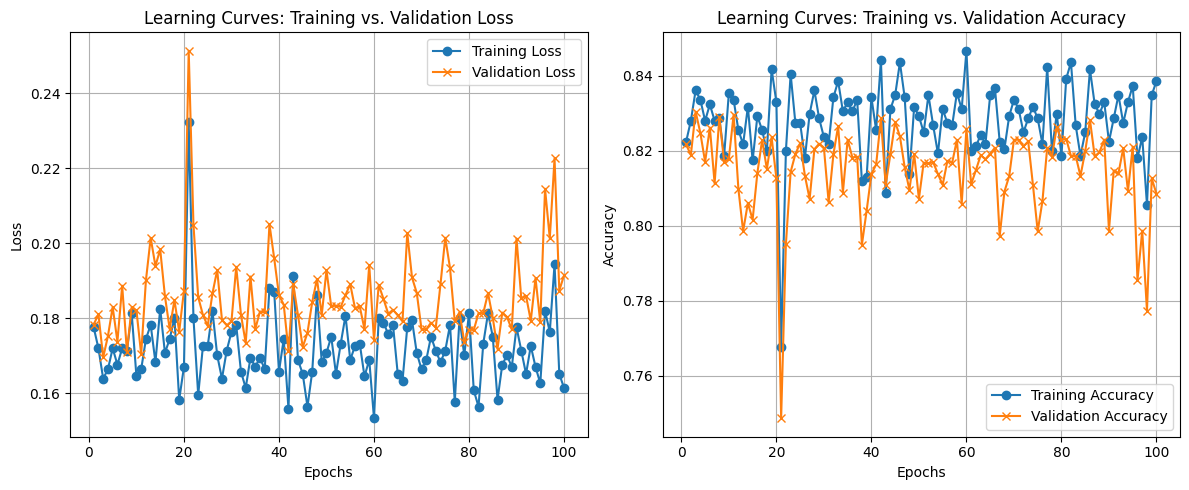

In [ ]:
# Plotting the learning curves for Loss
epochs = range(1, 101)
plt.figure(figsize=(12, 5))

# Loss curve
plt.subplot(1, 2, 1)
plt.plot(epochs, perceptron_acc.train_losses, label='Training Loss', marker='o')
plt.plot(epochs, perceptron_acc.val_losses, label='Validation Loss', marker='x')
plt.title('Learning Curves: Training vs. Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)

# Accuracy curve
plt.subplot(1, 2, 2)
plt.plot(epochs, perceptron_acc.train_accuracies, label='Training Accuracy', marker='o')
plt.plot(epochs, perceptron_acc.val_accuracies, label='Validation Accuracy', marker='x')
plt.title('Learning Curves: Training vs. Validation Accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
# Cross-validation function
def cross_validate(model, X, y, n_splits=5):
    kf = KFold(n_splits=n_splits, shuffle=True, random_state=42)
    scores = []
    for train_index, val_index in kf.split(X):
        X_train_fold, X_val_fold = X[train_index], X[val_index]
        y_train_fold, y_val_fold = y[train_index], y[val_index]
        model.train(X_train_fold, y_train_fold, X_val_fold, y_val_fold)
        y_pred = model.predict(X_val_fold)
        accuracy = np.mean(y_pred == y_val_fold)
        scores.append(accuracy)
    return scores

In [ ]:
# Cross-validation
cv_scores = cross_validate(PerceptronWithAccuracy(learning_rate=0.01, epochs=100), X_train_aligned, y_train)

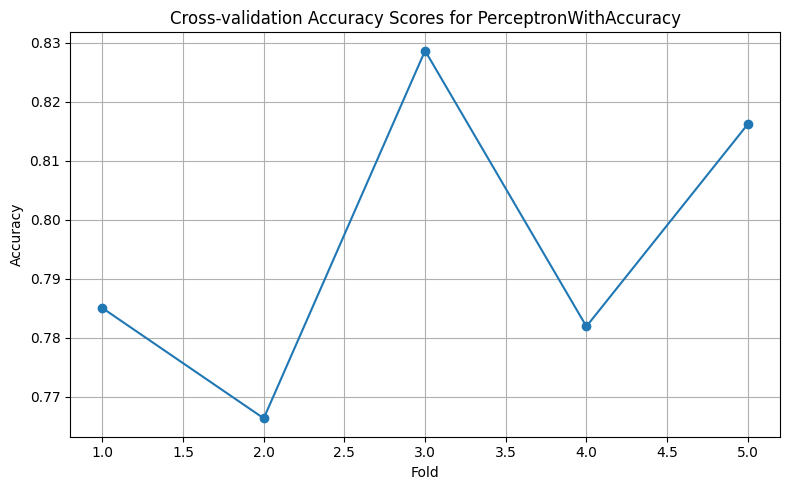

In [ ]:
# Plot the results
plt.figure(figsize=(8, 5))
plt.plot(range(1, len(cv_scores)+1), cv_scores, '-o')
plt.title('Cross-validation Accuracy Scores for PerceptronWithAccuracy')
plt.xlabel('Fold')
plt.ylabel('Accuracy')
plt.grid(True)
plt.tight_layout()
plt.show()

In [ ]:
# Initialize perceptron model
perceptron_acc = PerceptronWithAccuracy(learning_rate=0.01, epochs=1000)

# Train the model
perceptron_acc.train(X_train_aligned, y_train, X_val_aligned, y_val)

In [ ]:
# Assuming you have already trained the PerceptronWithAccuracy model named "perceptron_acc"
final_val_accuracy = perceptron_acc.val_accuracies[-1]
print("Validation Accuracy:", final_val_accuracy)

Validation Accuracy: 0.8019446956971185


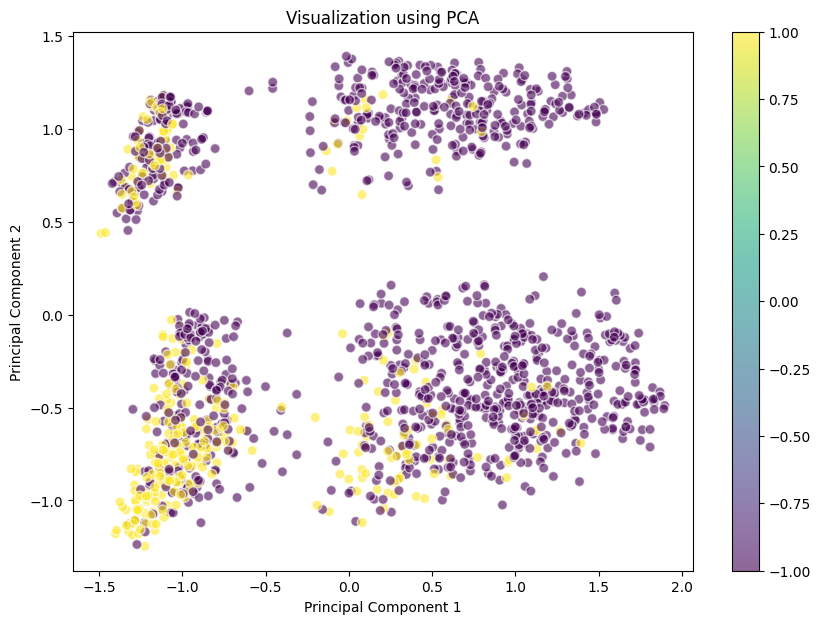

In [ ]:
# Apply PCA and reduce to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_train_aligned)

plt.figure(figsize=(10, 7))
plt.scatter(X_pca[:, 0], X_pca[:, 1], c=y_train, cmap='viridis', s=50, alpha=0.6, edgecolors='w')
plt.xlabel("Principal Component 1")
plt.ylabel("Principal Component 2")
plt.title("Visualization using PCA")
plt.colorbar()
plt.show()


In [ ]:
# Process the data again
def parse_libsvm_file(filename):
    with open(filename, 'r') as file:
        lines = file.readlines()

    X, y = [], []
    for line in lines:
        parts = line.strip().split()
        y.append(int(parts[0]))
        features = [0] * 123  # Initialize with zeros for 123 features
        for part in parts[1:]:
            index, value = part.split(":")
            index = int(index) - 1  # Convert 1-based index to 0-based
            features[index] = float(value)
        X.append(features)
    return X, y


In [ ]:
# File paths
train_file = "/content/drive/MyDrive/Colab Notebooks/DeepLearning/A1/a1.txt"
val_file = "/content/drive/MyDrive/Colab Notebooks/DeepLearning/A1/a1a.txt"

# Load the training and validation data
X_train_aligned, y_train = parse_libsvm_file(train_file)
X_val_aligned, y_val = parse_libsvm_file(val_file)

# Convert the labels from {-1, 1} to {0, 1} for binary crossentropy
y_train = [(label + 1) // 2 for label in y_train]
y_val = [(label + 1) // 2 for label in y_val]

# Normalize the features using MinMaxScaler
scaler = MinMaxScaler()
X_train_aligned = scaler.fit_transform(X_train_aligned)
X_val_aligned = scaler.transform(X_val_aligned)  # Use the same scaler to transform validation data

# Confirm the shape of the processed data
print(len(X_train_aligned), len(X_val_aligned), len(y_train), len(y_val))

1605 30956 1605 30956


In [ ]:
#Definethe MLP model
model = Sequential()
model.add(Dense(64, input_dim=123, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(32, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(1, activation='sigmoid'))

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

In [ ]:
y_train = np.array(y_train)
y_val = np.array(y_val)
# Train the model on the provided data.
MLP_history = model.fit(X_train_aligned, y_train, validation_data=(X_val_aligned, y_val), epochs=100, batch_size=32, verbose=0)

In [ ]:
last_epoch = MLP_history.epoch[-1]
print(f"Epoch {last_epoch+1}/{len(MLP_history.epoch)}")
print(f"loss: {MLP_history.history['loss'][-1]:.4f} - accuracy: {MLP_history.history['accuracy'][-1]:.4f} - val_loss: {MLP_history.history['val_loss'][-1]:.4f} - val_accuracy: {MLP_history.history['val_accuracy'][-1]:.4f}")

Epoch 100/100
loss: 0.1354 - accuracy: 0.9389 - val_loss: 0.6988 - val_accuracy: 0.8305


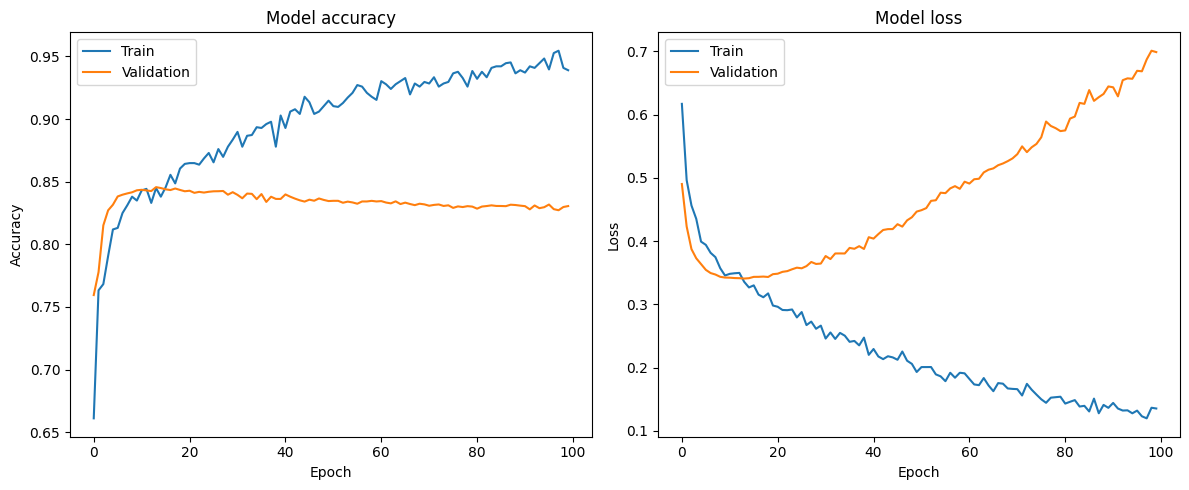

In [ ]:
#plot training history
def plot_training_history(history):
    # Plot training & validation accuracy values
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(history.history['accuracy'])
    plt.plot(history.history['val_accuracy'])
    plt.title('Model accuracy')
    plt.ylabel('Accuracy')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    # Plot training & validation loss values
    plt.subplot(1, 2, 2)
    plt.plot(history.history['loss'])
    plt.plot(history.history['val_loss'])
    plt.title('Model loss')
    plt.ylabel('Loss')
    plt.xlabel('Epoch')
    plt.legend(['Train', 'Validation'], loc='upper left')

    plt.tight_layout()
    plt.show()

# Visualize the training history
plot_training_history(MLP_history)

In [ ]:
def create_regularized_mlp_model():
    model = Sequential()

    # Input layer with L2 regularization
    model.add(Dense(128, activation='relu', kernel_regularizer=l2(0.01), input_shape=(123,)))

    # Hidden layer with L2 regularization
    model.add(Dense(64, activation='relu', kernel_regularizer=l2(0.01)))

    # Output layer
    model.add(Dense(1, activation='sigmoid'))

    # Compile the model
    model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

    return model

# Instantiate the model
regularized_model = create_regularized_mlp_model()
regularized_model.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_3 (Dense)             (None, 128)               15872     
                                                                 
 dense_4 (Dense)             (None, 64)                8256      
                                                                 
 dense_5 (Dense)             (None, 1)                 65        
                                                                 
Total params: 24193 (94.50 KB)
Trainable params: 24193 (94.50 KB)
Non-trainable params: 0 (0.00 Byte)
_________________________________________________________________


In [ ]:
# Train the model
re_MLP_history = regularized_model.fit(X_train_aligned, y_train, validation_data=(X_val_aligned, y_val), epochs=50, batch_size=32, verbose=0)

In [ ]:
last_epoch = re_MLP_history.epoch[-1]
print(f"Epoch {last_epoch+1}/{len(re_MLP_history.epoch)}")
print(f"loss: {re_MLP_history.history['loss'][-1]:.4f} - accuracy: {re_MLP_history.history['accuracy'][-1]:.4f} - val_loss: {re_MLP_history.history['val_loss'][-1]:.4f} - val_accuracy: {re_MLP_history.history['val_accuracy'][-1]:.4f}")

Epoch 50/50
loss: 0.2482 - accuracy: 0.9383 - val_loss: 0.5029 - val_accuracy: 0.8202


In [ ]:
# define model
model = create_regularized_mlp_model()

# define EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss',   # Monitoring and Verification Losses
                               patience=10,          # Allow verification loss to not improve for 10 epochs
                               restore_best_weights=True)  # Restoration of optimal weights

# Training models using callbacks
history = model.fit(X_train_aligned, y_train,
                    validation_data=(X_val_aligned, y_val),
                    epochs=100,
                    callbacks=[early_stopping])



Epoch 1/100
51/51 [==============================] - 6s 57ms/step - loss: 2.0064 - accuracy: 0.7396 - val_loss: 1.3828 - val_accuracy: 0.8093
Epoch 2/100
51/51 [==============================] - 3s 54ms/step - loss: 1.0782 - accuracy: 0.8212 - val_loss: 0.8243 - val_accuracy: 0.8368
Epoch 3/100
51/51 [==============================] - 6s 114ms/step - loss: 0.7029 - accuracy: 0.8312 - val_loss: 0.6013 - val_accuracy: 0.8349
Epoch 4/100
51/51 [==============================] - 6s 110ms/step - loss: 0.5517 - accuracy: 0.8361 - val_loss: 0.5021 - val_accuracy: 0.8417
Epoch 5/100
51/51 [==============================] - 5s 106ms/step - loss: 0.4901 - accuracy: 0.8312 - val_loss: 0.4624 - val_accuracy: 0.8384
Epoch 6/100
51/51 [==============================] - 2s 42ms/step - loss: 0.4412 - accuracy: 0.8442 - val_loss: 0.4395 - val_accuracy: 0.8402
Epoch 7/100
51/51 [==============================] - 5s 107ms/step - loss: 0.4256 - accuracy: 0.8368 - val_loss: 0.4330 - val_accuracy: 0.8361
Ep

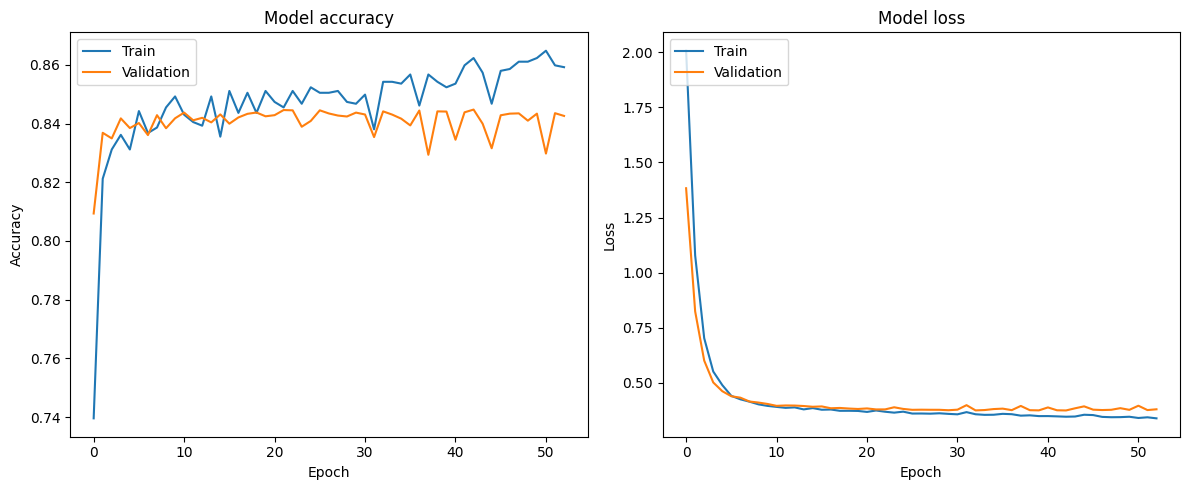

In [ ]:
plot_training_history(history)

In [ ]:
# Using models to predict validation sets
y_pred_prob = model.predict(X_val)
y_pred = (y_pred_prob > 0.5).astype(int).flatten()  # Convert probabilities to class labels (0 or 1)

# Calculating Recall, Precision and F1 Scores
recall = recall_score(y_val, y_pred)
precision = precision_score(y_val, y_pred)
f1 = f1_score(y_val, y_pred)

print(f"Recall: {recall:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")


968/968 [==============================] - 5s 5ms/step
Recall: 0.5889
Precision: 0.7153
F1 Score: 0.6460
